QC, Normalization, and Batch Correction to go from raw UMI counts --> expression matrix for analyses

In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(ggpubr, quietly = T)
    library(dplyr, quietly = T)
    library(reshape2, quietly = T)
})

data_path0 = '/data2/hratch/STAT4/'
data_path = '/data3/hratch/STAT4_v2/'

In [2]:
# load the counts
samples = list('5k_pbmc_v3_count', 'LB441_count', 'LB443_count')
cell_ranger_paths = lapply(samples, 
                           function(sample) paste0(data_path0, 'interim/', sample, '/outs/filtered_feature_bc_matrix/'))
raw_counts = lapply(cell_ranger_paths, 
                   function(path) Read10X(data.dir = path))  
                                    

In [3]:
samples = list('Control', 'Patient.2', 'Patient.1') # sample name annotation from manuscript
# generate unique barcodes across samples
for (i in 1:length(raw_counts)){
    d = raw_counts[[i]]
    new.cell.names<-rep(paste0('.', samples[[i]]), each = dim(d)[2])
    new.cell.names<-paste(colnames(d), new.cell.names)
    colnames(raw_counts[[i]]) = new.cell.names
 }     

In [4]:
# threshold on cell and feature cutoffs
so.list<-lapply(1:length(raw_counts), 
       function(i) CreateSeuratObject(counts = raw_counts[[i]], project = samples[[i]], 
                                     min.cells = 3, min.features = 200)) 
names(so.list)<-samples

# QC

In [5]:
# get mitochondrial percentage
for (sample in names(so.list)){
    so.list[[sample]][['percent.mt']]<-PercentageFeatureSet(so.list[[sample]], pattern = "^MT-")
}

If the number of unique features and the total counts are highly correlated, only need to filter on one of them

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



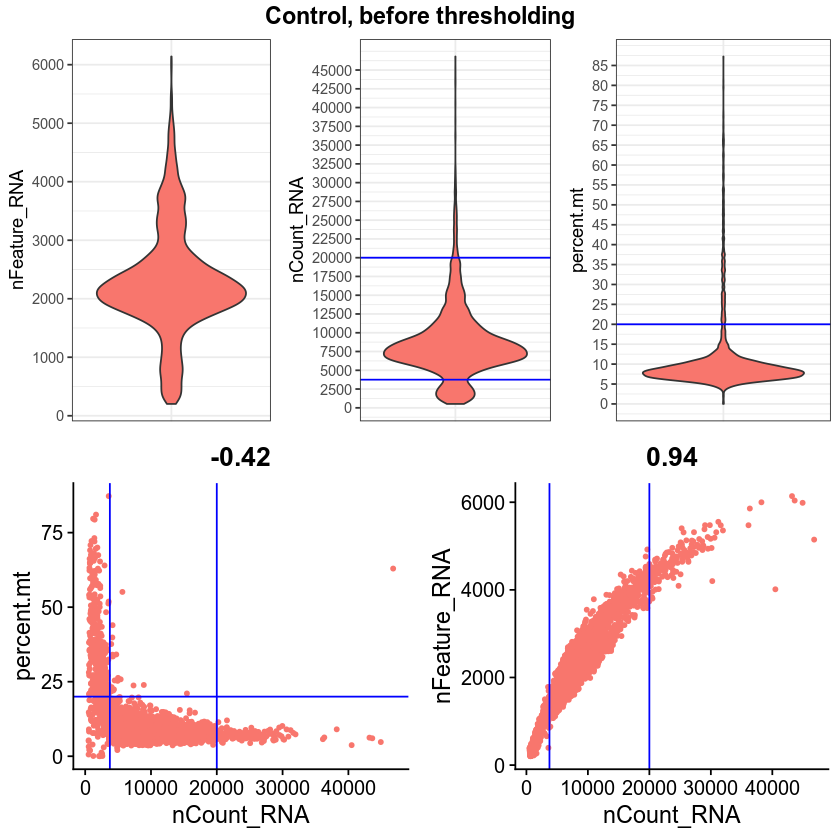

In [6]:
name = samples[[1]]
md<-so.list[[name]]@meta.data

nCount_RNA.upper<-20000
nCount_RNA.lower<-3750
percent.mt.upper<-20

g1Ai<-ggplot(data = md, aes(x = orig.ident, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g1Aii<-ggplot(data = md, aes(x = orig.ident, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
geom_hline(yintercept = nCount_RNA.upper, color = 'blue')+
geom_hline(yintercept = nCount_RNA.lower, color = 'blue')+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g1Aiii<-ggplot(data = md, aes(x = orig.ident, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
geom_hline(yintercept = percent.mt.upper, color = 'blue')+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g1A<-ggarrange(g1Ai, g1Aii, g1Aiii, ncol = 3)

g1Bi<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "percent.mt")+ theme(legend.position="none")+
geom_hline(yintercept = percent.mt.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.lower, color = 'blue')

g1Bii<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")+ 
theme(legend.position="none")+
geom_vline(xintercept = nCount_RNA.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.lower, color = 'blue')

g1B<-ggarrange(g1Bi, g1Bii, ncol = 2, nrow = 1)

g1<-ggarrange(g1A, g1B, ncol = 1, nrow = 2)
g1<-annotate_figure(g1, top = text_grob(paste0(name, ', before thresholding'), 
               color = "black", face = "bold", size = 14))

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     name, '_before_QC', ext), g1)} 
g1

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



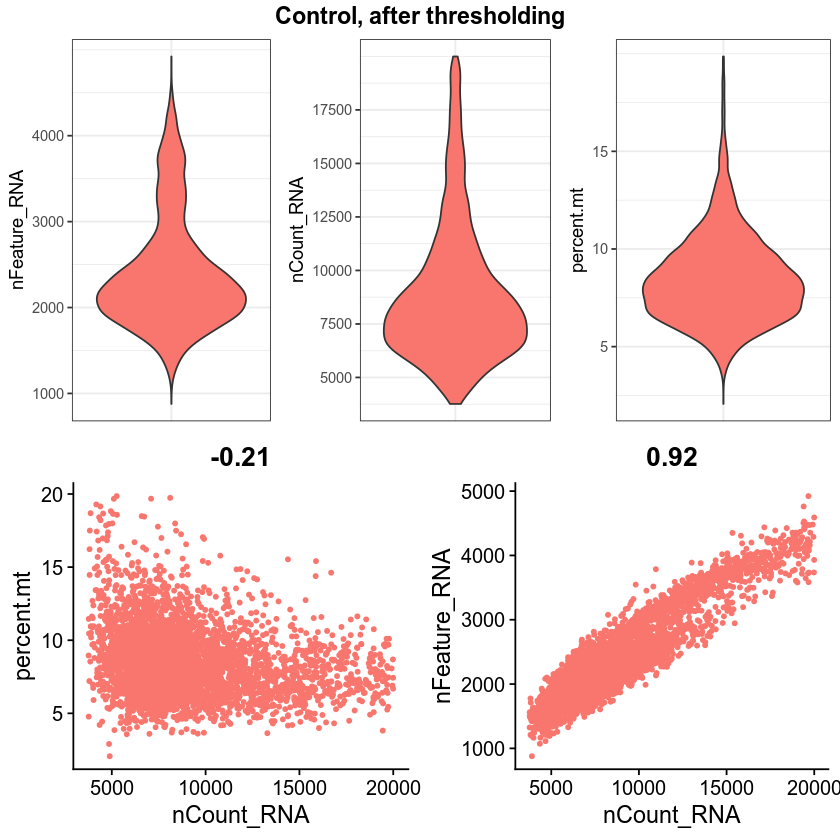

In [7]:
so.list[[name]] <- subset(so.list[[name]], subset = nCount_RNA > nCount_RNA.lower & 
                                  nCount_RNA < nCount_RNA.upper & 
                                   percent.mt < percent.mt.upper)
md<-so.list[[name]]@meta.data

g2Ai<-ggplot(data = md, aes(x = orig.ident, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2Aii<-ggplot(data = md, aes(x = orig.ident, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2Aiii<-ggplot(data = md, aes(x = orig.ident, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2A<-ggarrange(g2Ai, g2Aii, g2Aiii, ncol = 3)

g2Bi<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "percent.mt")+ theme(legend.position="none")

g2Bii<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")+ 
theme(legend.position="none")

g2B<-ggarrange(g2Bi, g2Bii, ncol = 2, nrow = 1)

g2<-ggarrange(g2A, g2B, ncol = 1, nrow = 2)
g2<-annotate_figure(g2, top = text_grob(paste0(name, ', after thresholding'), 
               color = "black", face = "bold", size = 14))
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     name, '_after_QC', ext), g2)} 
g2

Also.list add a feature threshold this time because of the kink in the scatterplot between nFeature and nCounts

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



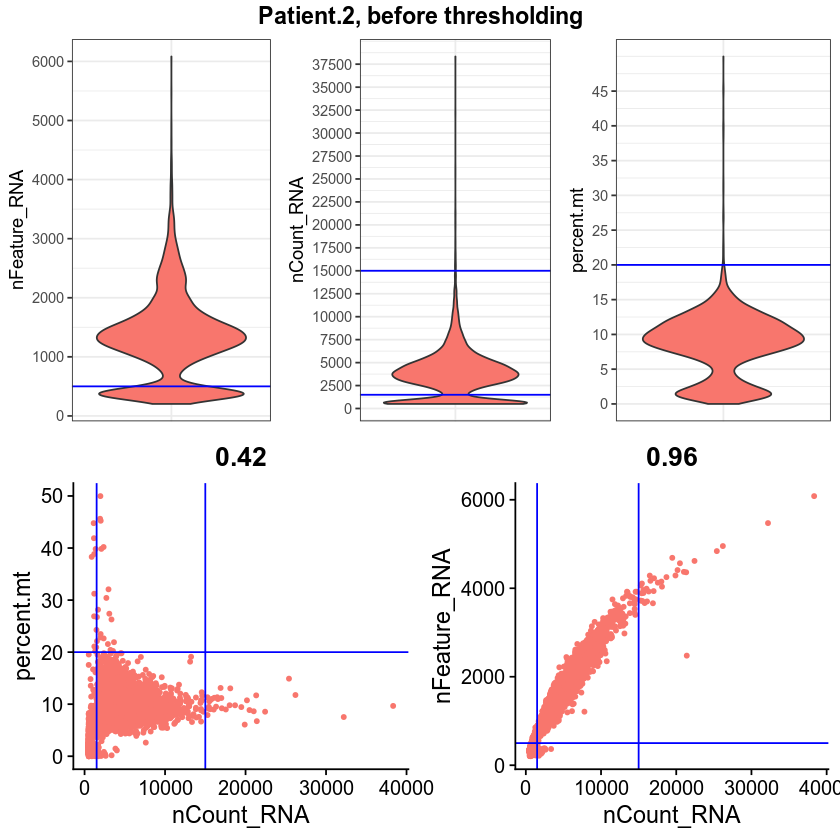

In [8]:
name = samples[[2]]
md<-so.list[[name]]@meta.data

nCount_RNA.upper<-15000
nCount_RNA.lower<-1500
nFeature_RNA.lower<-500
percent.mt.upper<-20

g1Ai<-ggplot(data = md, aes(x = orig.ident, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())+
geom_hline(yintercept = nFeature_RNA.lower, color = 'blue')

g1Aii<-ggplot(data = md, aes(x = orig.ident, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
geom_hline(yintercept = nCount_RNA.upper, color = 'blue')+
geom_hline(yintercept = nCount_RNA.lower, color = 'blue')+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g1Aiii<-ggplot(data = md, aes(x = orig.ident, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
geom_hline(yintercept = percent.mt.upper, color = 'blue')+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g1A<-ggarrange(g1Ai, g1Aii, g1Aiii, ncol = 3)

g1Bi<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "percent.mt")+ theme(legend.position="none")+
geom_hline(yintercept = percent.mt.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.lower, color = 'blue')

g1Bii<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")+ 
theme(legend.position="none")+
geom_vline(xintercept = nCount_RNA.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.lower, color = 'blue')+
geom_hline(yintercept = nFeature_RNA.lower, color = 'blue')

g1B<-ggarrange(g1Bi, g1Bii, ncol = 2, nrow = 1)

g1<-ggarrange(g1A, g1B, ncol = 1, nrow = 2)
g1<-annotate_figure(g1, top = text_grob(paste0(name, ', before thresholding'), 
               color = "black", face = "bold", size = 14))

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     name, '_before_QC', ext), g1)} 
g1

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



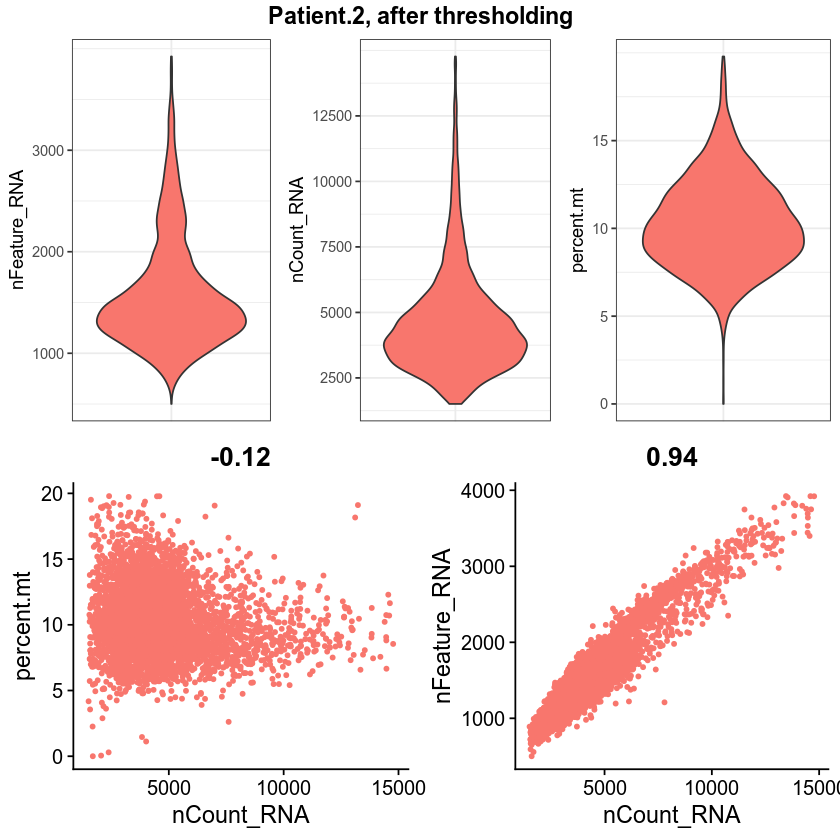

In [9]:
so.list[[name]] <- subset(so.list[[name]], subset = nCount_RNA > nCount_RNA.lower & 
                                  nCount_RNA < nCount_RNA.upper & 
                                   percent.mt < percent.mt.upper &
                                    nFeature_RNA > nFeature_RNA.lower)
md<-so.list[[name]]@meta.data

g2Ai<-ggplot(data = md, aes(x = orig.ident, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2Aii<-ggplot(data = md, aes(x = orig.ident, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2Aiii<-ggplot(data = md, aes(x = orig.ident, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2A<-ggarrange(g2Ai, g2Aii, g2Aiii, ncol = 3)

g2Bi<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "percent.mt")+ theme(legend.position="none")

g2Bii<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")+ 
theme(legend.position="none")

g2B<-ggarrange(g2Bi, g2Bii, ncol = 2, nrow = 1)

g2<-ggarrange(g2A, g2B, ncol = 1, nrow = 2)
g2<-annotate_figure(g2, top = text_grob(paste0(name, ', after thresholding'), 
               color = "black", face = "bold", size = 14))
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     name, '_after_QC', ext), g2)} 
g2

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



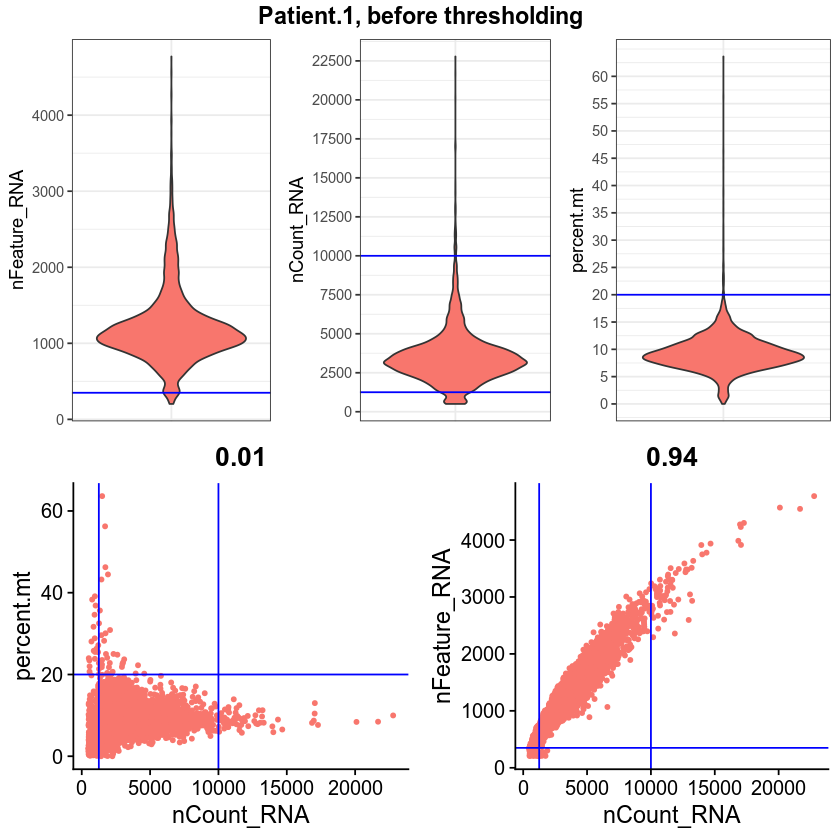

In [10]:
name = samples[[3]]
md<-so.list[[name]]@meta.data

nCount_RNA.upper<-10000
nCount_RNA.lower<-1250
nFeature_RNA.lower<-350
percent.mt.upper<-20

g1Ai<-ggplot(data = md, aes(x = orig.ident, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())+
geom_hline(yintercept = nFeature_RNA.lower, color = 'blue')

g1Aii<-ggplot(data = md, aes(x = orig.ident, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
geom_hline(yintercept = nCount_RNA.upper, color = 'blue')+
geom_hline(yintercept = nCount_RNA.lower, color = 'blue')+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g1Aiii<-ggplot(data = md, aes(x = orig.ident, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
geom_hline(yintercept = percent.mt.upper, color = 'blue')+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g1A<-ggarrange(g1Ai, g1Aii, g1Aiii, ncol = 3)

g1Bi<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "percent.mt")+ theme(legend.position="none")+
geom_hline(yintercept = percent.mt.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.lower, color = 'blue')

g1Bii<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")+ 
theme(legend.position="none")+
geom_vline(xintercept = nCount_RNA.upper, color = 'blue')+
geom_vline(xintercept = nCount_RNA.lower, color = 'blue')+
geom_hline(yintercept = nFeature_RNA.lower, color = 'blue')

g1B<-ggarrange(g1Bi, g1Bii, ncol = 2, nrow = 1)

g1<-ggarrange(g1A, g1B, ncol = 1, nrow = 2)
g1<-annotate_figure(g1, top = text_grob(paste0(name, ', before thresholding'), 
               color = "black", face = "bold", size = 14))

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     name, '_before_QC', ext), g1)} 
g1

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



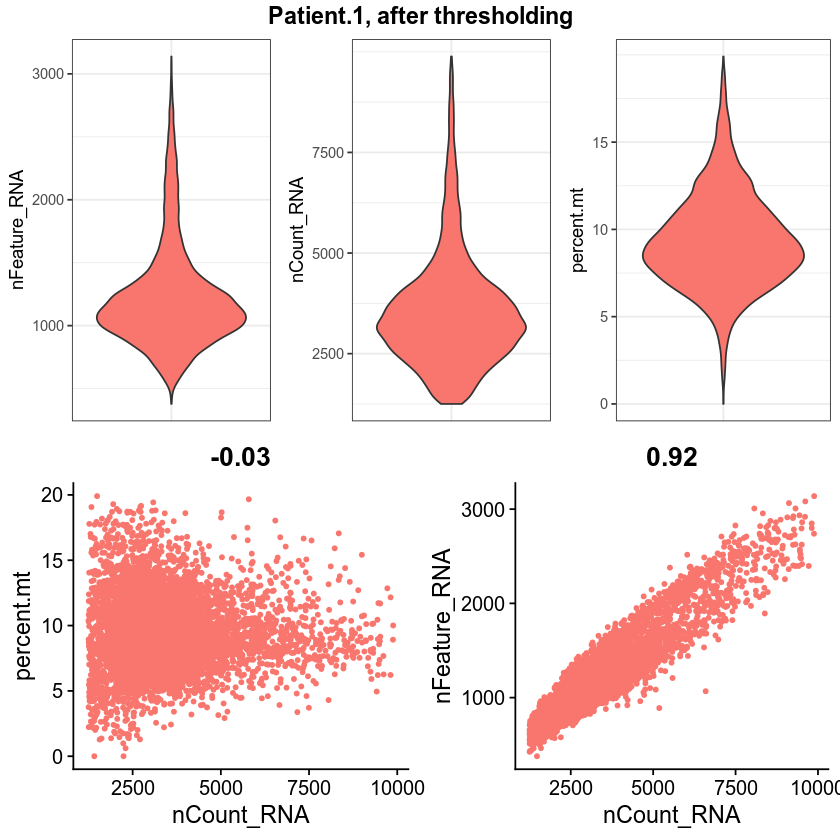

In [11]:
so.list[[name]] <- subset(so.list[[name]], subset = nCount_RNA > nCount_RNA.lower & 
                                  nCount_RNA < nCount_RNA.upper & 
                                   percent.mt < percent.mt.upper &
                                    nFeature_RNA > nFeature_RNA.lower)
md<-so.list[[name]]@meta.data

g2Ai<-ggplot(data = md, aes(x = orig.ident, y = nFeature_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nFeature_RNA']]), by = 1000),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2Aii<-ggplot(data = md, aes(x = orig.ident, y = nCount_RNA, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 2500),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2Aiii<-ggplot(data = md, aes(x = orig.ident, y = percent.mt, fill = 'red'))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
theme_bw()+theme(legend.position="none", axis.text.x=element_blank(), axis.ticks.x=element_blank(),
                axis.title.x=element_blank())

g2A<-ggarrange(g2Ai, g2Aii, g2Aiii, ncol = 3)

g2Bi<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "percent.mt")+ theme(legend.position="none")

g2Bii<-FeatureScatter(so.list[[name]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")+ 
theme(legend.position="none")

g2B<-ggarrange(g2Bi, g2Bii, ncol = 2, nrow = 1)

g2<-ggarrange(g2A, g2B, ncol = 1, nrow = 2)
g2<-annotate_figure(g2, top = text_grob(paste0(name, ', after thresholding'), 
               color = "black", face = "bold", size = 14))
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     name, '_after_QC', ext), g2)} 
g2

# Normalize 

In [12]:
so.list <- lapply(X = so.list, FUN = function(x){
    x <- NormalizeData(x, normalization.method = "LogNormalize", scale.factor = 1e6)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

# Batch Correct

Use the reciprocal PCA method

In [13]:
features <- SelectIntegrationFeatures(object.list = so.list)
so.list <- lapply(X = so.list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, npcs = 50, features = features, verbose = FALSE)
})

Demonstrate that the default 30 PCs used by integration in reciprocal PCA is reasonable:

[1] "Additional variance explained is <0.5% at 7 pcs"
[1] "Additional variance explained is <0.5% at 7 pcs"
[1] "Additional variance explained is <0.5% at 8 pcs"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



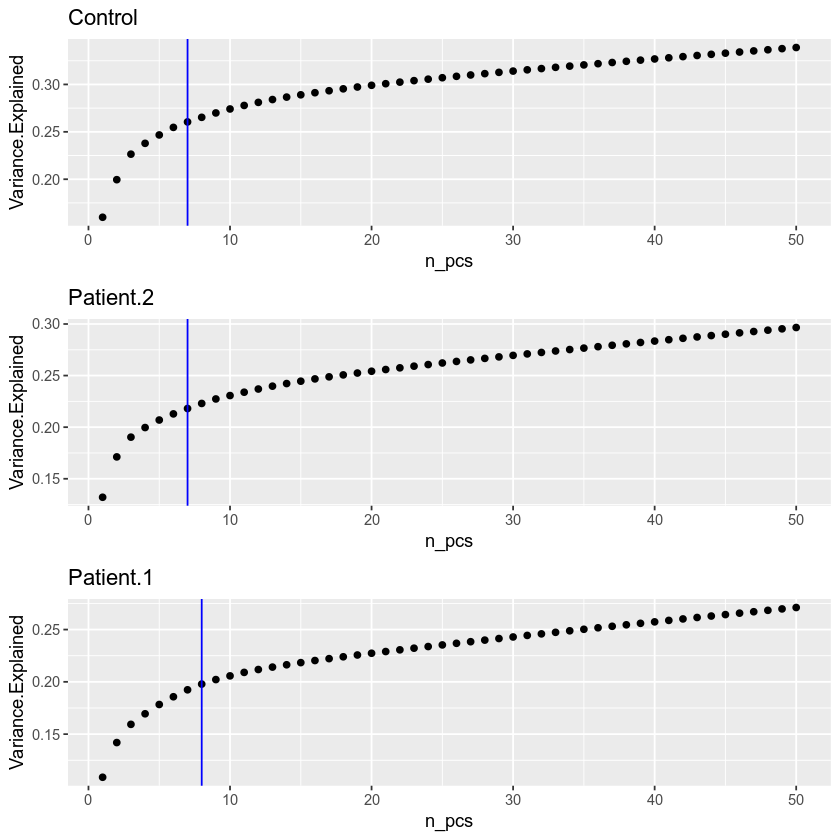

In [14]:
pca.var<-function(so, pc.thresh = 0.5){
    total_variance <- sum(matrixStats::rowVars(so@assays$RNA@scale.data))
    eigValues = (so@reductions$pca@stdev)^2
    varExplained = eigValues / total_variance


    viz_df = data.frame(varExplained)
    viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
    viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

    n_pcs = min(which(diff(viz_df$Variance.Explained) < (pc.thresh/100))) # which PC is the additional variance explained < pc.thresh%
    print(paste0('Additional variance explained is <', pc.thresh, '% at ', n_pcs, ' pcs')) # 48!
    g<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point() + 
    geom_vline(xintercept = n_pcs, color = 'blue')
    
    return(g)
}

g3<-lapply(names(so.list), function(name) pca.var(so.list[[name]])+ggtitle(name))
g3<-ggarrange(g3[[1]], g3[[2]], g3[[3]], nrow = 3)
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'sample_elbow_plot', ext), g3)}            
g3

In [37]:
pbmc.anchors <- FindIntegrationAnchors(object.list = so.list, anchor.features = features, 
                                       scale = F, # since already scaled above, according to documentation
                                       normalization.method = 'LogNormalize', 
                                       reduction = "rpca")
pbmc.integrated <- IntegrateData(anchorset = pbmc.anchors, normalization.method = 'LogNormalize')

In [16]:
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(pbmc.integrated) <- "integrated"

# Run the standard workflow for visualization and clustering
pbmc.integrated <- ScaleData(pbmc.integrated, verbose = FALSE)
pbmc.integrated <- RunPCA(pbmc.integrated, npcs = 50, verbose = FALSE)

Demonstrate that the default 30 PCs used by integration in reciprocal PCA is reasonable:

[1] "Additional variance explained is <0.1% at 47 pcs"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



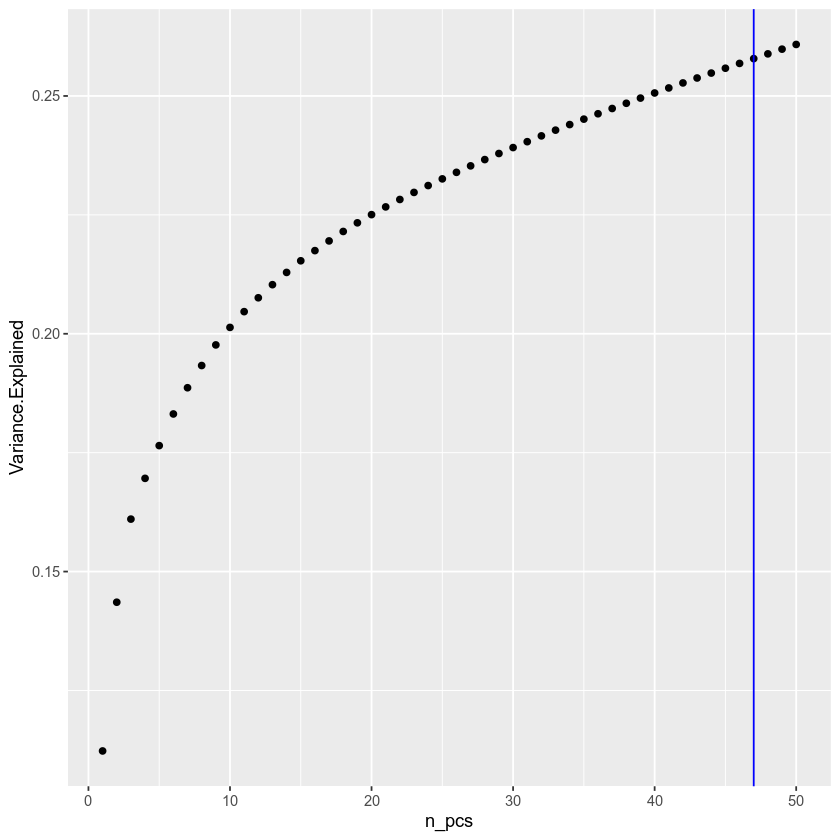

In [17]:
pc.thresh<-0.1
total_variance <- sum(matrixStats::rowVars(pbmc.integrated@assays$integrated@scale.data))
eigValues = (pbmc.integrated@reductions$pca@stdev)^2
varExplained = eigValues / total_variance


viz_df = data.frame(varExplained)
viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

n_pcs = min(which(diff(viz_df$Variance.Explained) < (pc.thresh/100))) # which PC is the additional variance explained < pc.thresh%
print(paste0('Additional variance explained is <', pc.thresh, '% at ', n_pcs, ' pcs')) 
g4<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point() + 
geom_vline(xintercept = n_pcs, color = 'blue')

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'integrated_elbow_plot', ext), g4)}     

g4

In [18]:
suppressWarnings({
    suppressMessages({
        pbmc.integrated <- RunUMAP(pbmc.integrated, reduction = "pca", dims = 1:n_pcs)
        pbmc.integrated <- FindNeighbors(pbmc.integrated, reduction = "pca", dims = 1:n_pcs)
        pbmc.integrated <- FindClusters(pbmc.integrated, resolution = 0.5)
    })
})

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 15186
Number of edges: 690344

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9179
Number of communities: 17
Elapsed time: 2 seconds


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



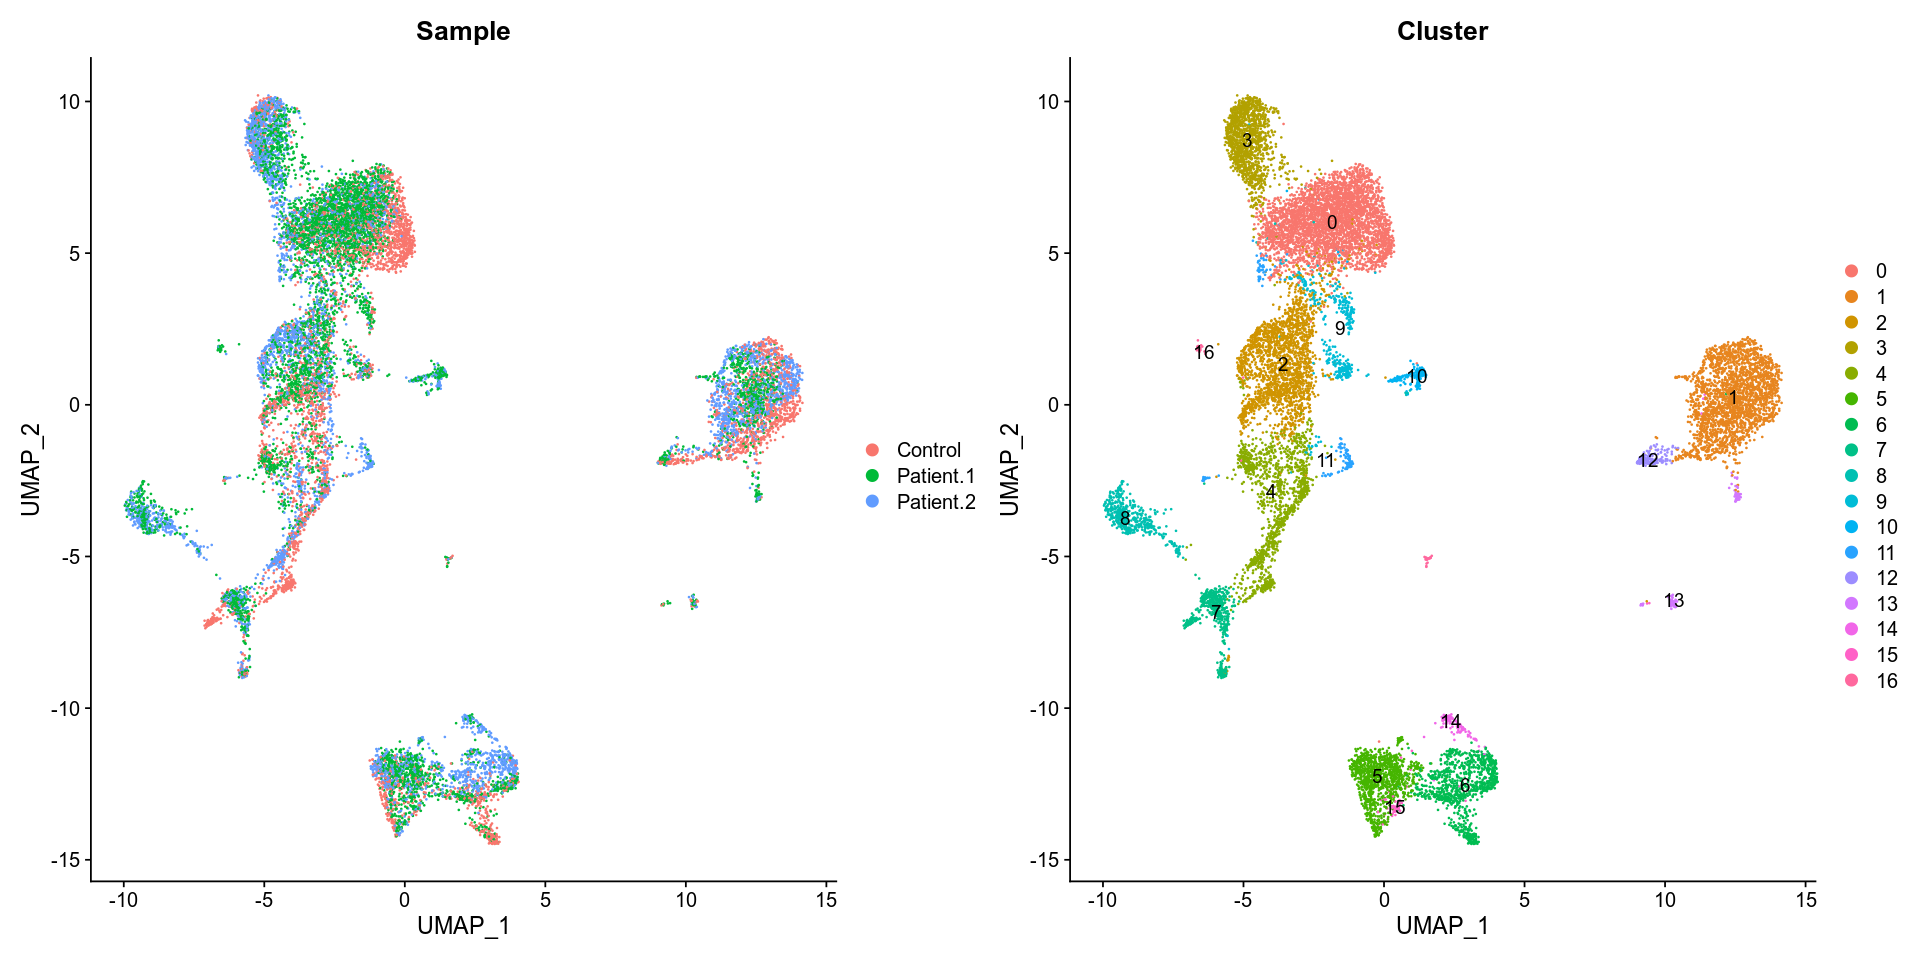

In [19]:
h_ = 8
w_ = 16
options(repr.plot.height=h_, repr.plot.width=w_)
g5a <- DimPlot(pbmc.integrated, reduction = "umap", group.by = "orig.ident", shuffle = T, label = F)+
ggtitle('Sample')
g5c <- DimPlot(pbmc.integrated, reduction = "umap", group.by = "seurat_clusters", shuffle = T,  label = T)+
ggtitle('Cluster')

g5<-g5a + g5c
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'UMAP', ext), g5)}     
g5

# Double check clusters by QC

In [20]:
md<-pbmc.integrated@meta.data

In [21]:
# counts
table(md$seurat_clusters)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3765 2351 2082 1328 1276 1123  947  550  511  385  181  163  157  143  118   57 
  16 
  49 

In [22]:
# frequency
100*table(md$seurat_clusters)/dim(pbmc.integrated)[[2]]


         0          1          2          3          4          5          6 
24.7925721 15.4813644 13.7099960  8.7448966  8.4024760  7.3949691  6.2360068 
         7          8          9         10         11         12         13 
 3.6217569  3.3649414  2.5352298  1.1918873  1.0733570  1.0338470  0.9416568 
        14         15         16 
 0.7770315  0.3753457  0.3226656 

In [23]:
cell.counts<-count(md, seurat_clusters, orig.ident)
cell.counts<-dcast(cell.counts, orig.ident ~ seurat_clusters, value.var="n")
rownames(cell.counts)<-cell.counts$orig.ident
cell.counts<-cell.counts[colnames(cell.counts) != 'orig.ident']
cell.counts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Control,1177,862,560,157,564,245,264,177,NA,100,1,13,73,30,NA,12,5
Patient.1,2064,590,850,474,302,555,281,221,242,201,120,28,55,69,30,31,39
Patient.2,524,899,672,697,410,323,402,152,269,84,60,122,29,44,88,14,5


In [24]:
# frequency of each cluster per patient
cell.freq<-t(apply(cell.counts, 1, function(i) 100*(i/sum(i[!is.na(i)]))))
cell.freq

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Control,27.75943,20.330189,13.20755,3.702830,13.301887,5.778302,6.226415,4.174528,NA,2.358491,0.02358491,0.3066038,1.7216981,0.7075472,NA,0.2830189,0.1179245
Patient.1,33.55007,9.590377,13.81664,7.704811,4.908973,9.021456,4.567620,3.592328,3.933680,3.267230,1.95058518,0.4551365,0.8940182,1.1215865,0.4876463,0.5039012,0.6339402
Patient.2,10.93033,18.752607,14.01752,14.539007,8.552357,6.737589,8.385482,3.170630,5.611181,1.752190,1.25156446,2.5448477,0.6049228,0.9178139,1.8356279,0.2920317,0.1042970


Warning message:
“Groups with fewer than two data points have been dropped.”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



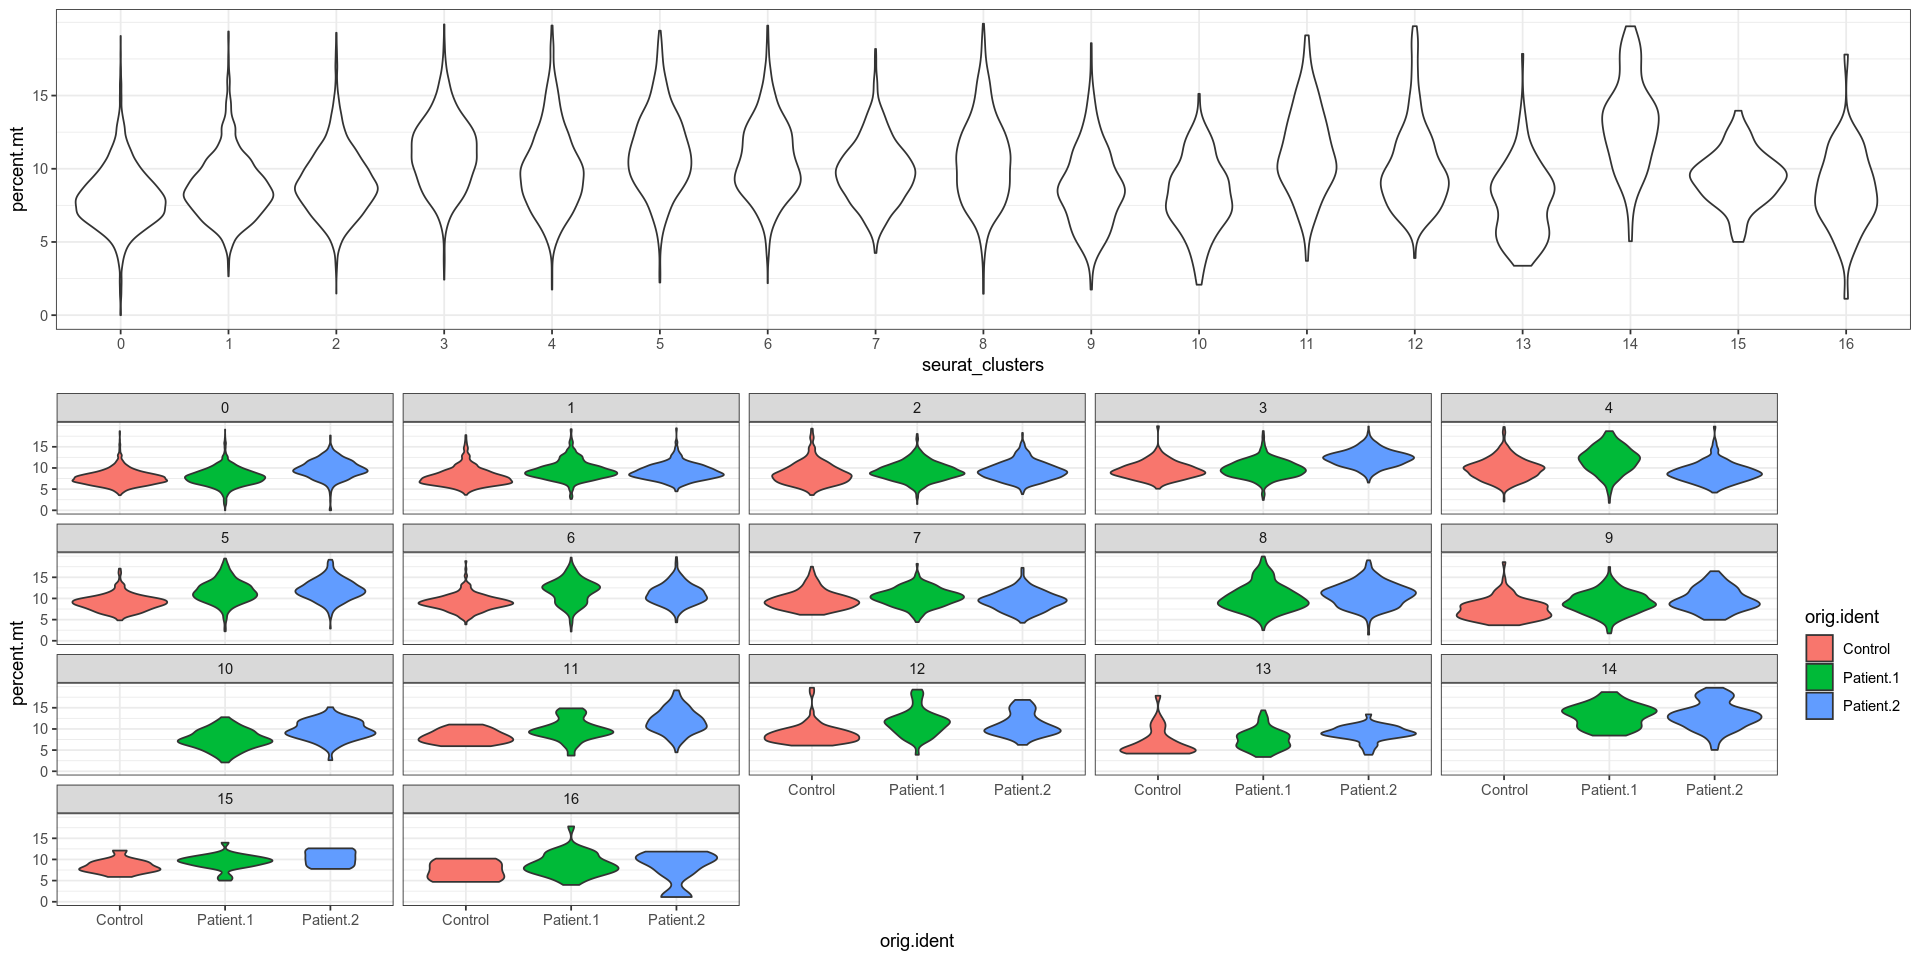

In [25]:
g6A<-ggplot(data = md, aes(x = seurat_clusters, y = percent.mt))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
theme_bw()

g6B<-ggplot(data = md, aes(y = percent.mt, x = orig.ident, fill = orig.ident))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['percent.mt']]), by = 5),1))+
theme_bw()+facet_wrap(~seurat_clusters)

g6<-ggarrange(g6A, g6B, nrow = 2, heights = c(0.4, 0.6))
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'MT_QC_integrated', ext), g6)}     
g6

Warning message:
“Groups with fewer than two data points have been dropped.”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



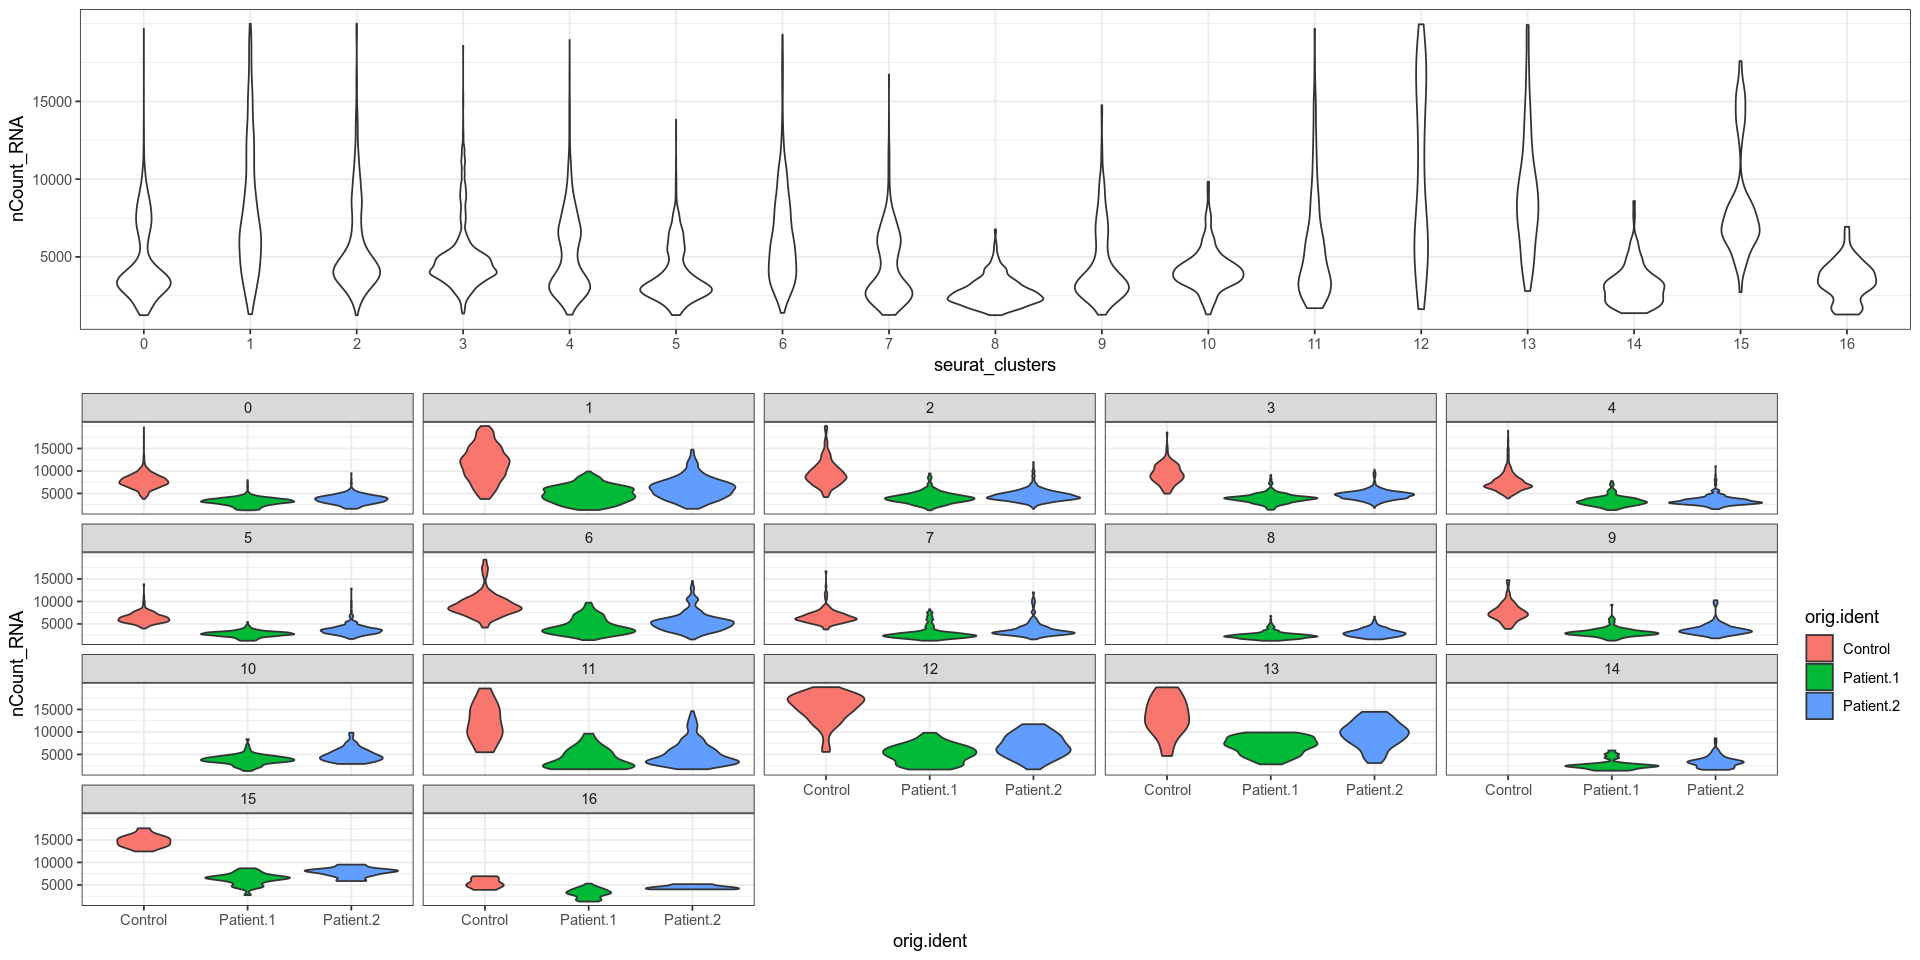

In [26]:
g7A<-ggplot(data = md, aes(x = seurat_clusters, y = nCount_RNA))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 5000),1))+
theme_bw()

g7B<-ggplot(data = md, aes(y = nCount_RNA, x = orig.ident, fill = orig.ident))+geom_violin()+
scale_y_continuous(breaks = round(seq(0, max(md[['nCount_RNA']]), by = 5000),1))+
theme_bw()+facet_wrap(~seurat_clusters)

g7<-ggarrange(g7A, g7B, nrow = 2, heights = c(0.4, 0.6))
for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'MT_QC_integrated', ext), g7)}    
g7

Clusters 8, 10, and 14 are patient-specific. We may or may not want to disregard them. Reasons to disregard:

1) they are smaller size (<2% of population in for clusters 10 and 14)
2) cluster 14 has higher MT
3) all are lower in the nCounts. 

Note, for MT and nCounts, they are still comparable in distribution within-sample, so this may or may not be justified. For the size, these could be rare populations. 

In [27]:
# final formating before saving
pbmc.integrated@meta.data[['orig.ident']]<-factor(pbmc.integrated@meta.data$orig.ident, 
                                                  levels = c('Control', 'Patient.1', 'Patient.2'))

# make sure that the log(1+CPM) also has a scaled matrix
DefaultAssay(pbmc.integrated)<-'RNA'
pbmc.integrated <- ScaleData(pbmc.integrated, features = rownames(pbmc.integrated))
DefaultAssay(pbmc.integrated)<-'integrated'

saveRDS(pbmc.integrated, 
        file = paste0(data_path, 'interim/pbmc_integrated.RDS'))

Centering and scaling data matrix



# Comparison to original processing

In [28]:
cells<-colnames(pbmc.integrated)
cells<-sapply(cells, function(x) gsub('Patient.1', 'LB443', x))
cells<-sapply(cells, function(x) gsub('Patient.2', 'LB441', x))
cells<-sapply(cells, function(x) gsub('-1', '', x))              
cells<-unname(cells)
cells<-unlist(cells)

In [29]:
# load the original processed dataset
pbmc.og = readRDS(file = paste0(data_path0, 'processed/pbmc_integrated.RDS'))
md.og<-pbmc.og@meta.data
cells.og<-colnames(pbmc.og)

In [30]:
print(paste0('There are ', length(setdiff(cells, cells.og)), 
      ' cells present in the new version that were not there previously'))

print(paste0('There are ', length(setdiff(cells.og, cells)), 
      ' cells present in the old version that are not there in the new version'))

[1] "There are 0 cells present in the new version that were not there previously"
[1] "There are 4043 cells present in the old version that are not there in the new version"


The cells present in the new version:

Proportion of dropped cells from original processing by cluster, where 4,5,10, and 13 were cluster specific

In [31]:
dropped.clusters<-list()
cat<-'seurat_clusters'
for (cat.name in sort(unique(md.og[[cat]]))){
    cat.cells<-rownames(md.og[md.og[[cat]] == cat.name,])
    dropped<-setdiff(cat.cells, cells)
    dropped.clusters[[cat.name]]=length(dropped)/length(cat.cells)
}

print('The proportion of cells dropped from each cluster with the new preprocessing step is:')
dropped.clusters

[1] "The proportion of cells dropped from each cluster with the new preprocessing step is:"


$`0`
[1] 0.02883326

$`1`
[1] 0.06680244

$`2`
[1] 0.09820628

$`3`
[1] 0.05331412

$`4`
[1] 0.9978054

$`5`
[1] 0.99631

$`6`
[1] 0.05420267

$`7`
[1] 0.05437553

$`8`
[1] 0.01092354

$`9`
[1] 0.04276986

$`10`
[1] 0.4315197

$`11`
[1] 0.1239669

$`12`
[1] 0.3653846

$`13`
[1] 0.1025641

$`14`
[1] 0.05035971

$`15`
[1] 0.953125

$`16`
[1] 0.6608696

Here are how the new patient specific clusters (8, 10, and 14) are distributed across their old labels (new is the row, old is the column):

In [32]:
cluster.counts<-pbmc.integrated@meta.data
cluster.counts['cluster.og']<-unlist(unname(setNames(md.og$seurat_clusters, rownames(md.og))[cells]))
cluster.counts<-cluster.counts[c('seurat_clusters', 'cluster.og')]
colnames(cluster.counts)<-c('new', 'old')
cluster.counts<-count(cluster.counts, new, old)
cluster.counts<-dcast(cluster.counts, new ~ old, value.var="n")
rownames(cluster.counts)<-cluster.counts$new
cluster.counts<-cluster.counts[colnames(cluster.counts) != 'new']
cluster.counts[c('8', '10', '14'), ]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
8,80,NA,60,NA,NA,3,36,33,10,NA,280,NA,NA,2,3,4,NA
10,33,NA,4,NA,2,NA,NA,2,3,NA,2,NA,NA,135,NA,NA,NA
14,NA,1,NA,74,NA,1,NA,NA,NA,35,6,NA,NA,NA,1,NA,NA


It appears the new cluster 8 corresponds to clusters 10 in the old version, which was also patient-specific: 

In [33]:
table(md.og[md.og$seurat_clusters =='10', 'orig.ident'])


Control   LB441   LB443 
     32     184     317 

Similarly, cluster the new cluster 10 corresponds to the old cluster 13, which was also patient-specific:

In [34]:
table(md.og[md.og$seurat_clusters =='13', 'orig.ident'])


LB441 LB443 
   52   104 

In [35]:
cluster.counts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,3631,NA,74,4,NA,NA,NA,22,19,2,2,NA,NA,NA,10,1,NA
1,NA,2281,NA,NA,NA,1,1,NA,NA,NA,5,57,5,NA,NA,NA,1
2,216,NA,1625,NA,1,NA,NA,230,4,2,NA,NA,NA,1,3,NA,NA
3,337,NA,5,NA,NA,NA,NA,19,955,NA,4,NA,NA,NA,8,NA,NA
4,NA,NA,19,1,NA,NA,603,648,1,NA,3,NA,NA,NA,NA,1,NA
5,NA,NA,NA,653,NA,NA,NA,NA,NA,470,NA,NA,NA,NA,NA,NA,NA
6,NA,1,NA,549,NA,NA,2,NA,NA,395,NA,NA,NA,NA,NA,NA,NA
7,NA,NA,NA,NA,NA,NA,550,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,80,NA,60,NA,NA,3,36,33,10,NA,280,NA,NA,2,3,4,NA
